# RNN models for sentence classification 

* Simple LSTM for Sequence Classification
* LSTM For Sequence Classification With Dropout
* LSTM and Convolutional Neural Network For Sequence Classification

## load data 

In [1]:
import pickle 
with open('labeled_essay_dics.pickle', 'rb') as handle:
    label_sents = pickle.load(handle)

In [2]:
# compute and store and the {sents: label} into one dic
all_label_sents = {}
for key in label_sents.keys():
    this_essay = label_sents[key]
    for s in this_essay.keys():
        all_label_sents[s] = this_essay[s]

## data preprocessing 

In [3]:
import numpy as np
import re
import itertools
from collections import Counter

In [4]:
"""
Original taken from https://github.com/dennybritz/cnn-text-classification-tf
"""


def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

In [5]:
def clear_split_str(s):
    strip_s = s.strip()
    clear_s = clean_str(strip_s)
    s_text = clear_s.split(" ")
    return s_text

In [6]:
texts = []
for key in all_label_sents.keys():
    this_value = all_label_sents[key]
    clear_key = clear_split_str(key)
    texts = texts + clear_key

In [7]:
print (len(set(texts)))

7701


In [8]:
## >> ? need to choose the top 5000 words here 
# from nltk import FreqDist
# fdist1 = FreqDist(texts)
# texts = [w for w in fdist1 if fdist1[w] > 10]
# # print (texts)
# print (len(texts))

In [9]:
vocab = sorted(set(texts))
vocab_to_int = {c: i for i, c in enumerate(vocab)}
int_to_vocab = dict(enumerate(vocab))

In [10]:
print (vocab_to_int['because'])

707


In [11]:
def encoded_txt(text):
    return np.array([vocab_to_int[c] for c in text], dtype=np.int32)

In [12]:
## >> remove low frequency words 
# def encoded_txt(text):
#     test = []
#     for item in text:
#         if item in vocab_to_int:
#             test.append(vocab_to_int[item])
#     return np.array(test)

In [13]:
# clear data and store in one dictionary
X = []
encode_X = []
y = []
for key in all_label_sents.keys():
    this_value = all_label_sents[key]
    clear_key = clear_split_str(key)
    X.append(clear_key)
    encode_X.append(encoded_txt(clear_key))
    y.append(this_value)

In [14]:
print (y[1:100])

['Premise', 'Premise', 'MajorClaim', 'Premise', 'MajorClaim', 'Premise', 'Premise', 'Premise', 'Premise', 'Premise', 'Empty', 'Premise', 'Premise', 'MajorClaim', 'Premise', 'Empty', 'Premise', 'Premise', 'Premise', 'Premise', 'Premise', 'Empty', 'MajorClaim', 'Premise', 'Claim', 'Claim', 'MajorClaim', 'Premise', 'Claim', 'Empty', 'Empty', 'MajorClaim', 'Premise', 'MajorClaim', 'Empty', 'MajorClaim', 'Claim', 'Empty', 'Premise', 'Claim', 'Empty', 'Premise', 'Premise', 'Premise', 'Premise', 'Empty', 'Premise', 'Claim', 'Empty', 'Empty', 'Empty', 'Claim', 'Claim', 'Claim', 'Empty', 'Premise', 'Premise', 'Premise', 'Claim', 'MajorClaim', 'Premise', 'Claim', 'Empty', 'Premise', 'Premise', 'Claim', 'Claim', 'Premise', 'Claim', 'Premise', 'Premise', 'Empty', 'Premise', 'Empty', 'Empty', 'Empty', 'Premise', 'Claim', 'Empty', 'Premise', 'Premise', 'Claim', 'Premise', 'Premise', 'MajorClaim', 'Premise', 'Premise', 'Empty', 'Empty', 'Empty', 'Premise', 'Premise', 'Claim', 'Premise', 'Premise', 'C

In [15]:
encode_y = []
for s in y:
    if s == 'Claim':
        encode_y.append([1,0,0,0])
    elif s == 'Premise':
        encode_y.append([0,1,0,0])
    elif s == 'Empty':
        encode_y.append([0,0,1,0])
    else: 
        encode_y.append([0,0,0,1])

In [16]:
length = int(len(X) * 0.9)
X_train = encode_X[0:length]
y_train = encode_y[0:length]
X_test = encode_X[length:]
y_test = encode_y[length:]

In [17]:
print (len(X_train), len(y_train), len(X_test), len(y_test))

6369 6369 708 708


In [18]:
print (encode_X[1000], encode_y[1000])
print (X_train[1000], y_train[1000])

[6684 2243 5491 3306 7598 7322 3953  400 3633] [0, 1, 0, 0]
[6684 2243 5491 3306 7598 7322 3953  400 3633] [0, 1, 0, 0]


In [19]:
max_lenth = 0
for item in X:
    if len(item) > max_lenth:
        max_lenth = len(item)

print ("max sentence length is: " + str(max_lenth))

max sentence length is: 72


## Simple LSTM for Sequence Classification

In [20]:
import numpy
# from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
# fix random seed for reproducibility
numpy.random.seed(7)

Using TensorFlow backend.


In [21]:
# truncate and pad input sequences
max_sent_length = 72
X_train = sequence.pad_sequences(X_train, maxlen=max_sent_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_sent_length)

In [22]:
# load the dataset but only keep the top n words, zero the rest
# top_words = 7701
top_words = len(vocab)
# (X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=top_words)

In [23]:
# create the model
embedding_vecor_length = 32
model1 = Sequential()
model1.add(Embedding(top_words, embedding_vecor_length, input_length=max_sent_length))
model1.add(LSTM(100))
model1.add(Dense(4, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model1.summary())
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3, batch_size=64)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 72, 32)            246432    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 404       
Total params: 300,036
Trainable params: 300,036
Non-trainable params: 0
_________________________________________________________________
None
Train on 6369 samples, validate on 708 samples
Epoch 1/3
6369/6369 [==============================] - 31s - loss: 0.5269 - acc: 0.7459 - val_loss: 0.5055 - val_acc: 0.7521
Epoch 2/3
6369/6369 [==============================] - 31s - loss: 0.4743 - acc: 0.7892 - val_loss: 0.4647 - val_acc: 0.7835
Epoch 3/3
6369/6369 [==============================] - 31s - loss: 0.3911 - acc: 0.8280 - val_loss

In [24]:
# Final evaluation of the model
scores = model1.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 81.00%


## 2. LSTM For Sequence Classification With Dropout

In [25]:
from keras.layers import Dropout
model2 = Sequential()
model2.add(Embedding(top_words, embedding_vecor_length, input_length=max_sent_length))
model2.add(Dropout(0.2))
model2.add(LSTM(100))
model2.add(Dropout(0.2))
model2.add(Dense(4, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model2.summary())
model2.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores2 = model2.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores2[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 72, 32)            246432    
_________________________________________________________________
dropout_1 (Dropout)          (None, 72, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 300,036
Trainable params: 300,036
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6369/6369 [==============================] - 33s - loss: 0.5307 - acc: 0.7444    
Epoch 2/3
6369/6369 [==================

## LSTM and Convolutional Neural Network For Sequence Classification

In [26]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [27]:
# create the model
embedding_vecor_length = 32
model3 = Sequential()
model3.add(Embedding(top_words, embedding_vecor_length, input_length=max_sent_length))
model3.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model3.add(MaxPooling1D(pool_size=2))
model3.add(LSTM(100))
model3.add(Dense(4, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model3.summary())
model3.fit(X_train, y_train, epochs=3, batch_size=64)
# Final evaluation of the model
scores3 = model3.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores3[1]*100))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 72, 32)            246432    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 32)            3104      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 36, 32)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 404       
Total params: 303,140
Trainable params: 303,140
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/3
6369/6369 [==============================] - 19s - loss: 0.5311 - acc: 0.7454    
Epoch 2/3
6369/6369 [==================

In [28]:
ttt = model3.predict(X_test)

In [29]:
# print (y_test)

## CNN model

In [46]:
from keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Convolution1D, Embedding
from keras.layers.merge import Concatenate
from keras.models import Sequential, Model

In [47]:
# Model Hyperparameters
embedding_dim = 300
filter_sizes = (3, 8)
num_filters = 10
dropout_prob = (0.5, 0.8)
hidden_dims = 50

# Training parameters
batch_size = 64
num_epochs = 10

# Prepossessing parameters
sequence_length = 72
max_words = 5000

In [48]:

input_shape = (sequence_length,)
model_input = Input(shape=input_shape)

In [49]:
z = Embedding(top_words, embedding_vecor_length, input_length=max_sent_length)(model_input)

In [50]:
z = Dropout(dropout_prob[0])(z)

In [51]:
# Convolutional block
conv_blocks = []
for sz in filter_sizes:
    conv = Convolution1D(filters=num_filters,
                         kernel_size=sz,
                         padding="valid",
                         activation="relu",
                         strides=1)(z)
    conv = MaxPooling1D(pool_size=2)(conv)
    conv = Flatten()(conv)
    conv_blocks.append(conv)

In [52]:
z = Concatenate()(conv_blocks) if len(conv_blocks) > 1 else conv_blocks[0]

z = Dropout(dropout_prob[1])(z)
z = Dense(hidden_dims, activation="relu")(z)
model_output = Dense(4, activation="sigmoid")(z)

model4 = Model(model_input, model_output)
model4.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [53]:
# Train the model
model4.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(X_test, y_test), verbose=2)

Train on 6369 samples, validate on 708 samples
Epoch 1/10
2s - loss: 0.5302 - acc: 0.7458 - val_loss: 0.5015 - val_acc: 0.7500
Epoch 2/10
2s - loss: 0.4944 - acc: 0.7579 - val_loss: 0.4805 - val_acc: 0.7698
Epoch 3/10
2s - loss: 0.4710 - acc: 0.7778 - val_loss: 0.4544 - val_acc: 0.7977
Epoch 4/10
2s - loss: 0.4281 - acc: 0.8101 - val_loss: 0.4256 - val_acc: 0.8104
Epoch 5/10
2s - loss: 0.3849 - acc: 0.8330 - val_loss: 0.4116 - val_acc: 0.8136
Epoch 6/10
2s - loss: 0.3539 - acc: 0.8460 - val_loss: 0.4175 - val_acc: 0.8139
Epoch 7/10
2s - loss: 0.3349 - acc: 0.8510 - val_loss: 0.4192 - val_acc: 0.8146
Epoch 8/10
2s - loss: 0.3133 - acc: 0.8608 - val_loss: 0.4332 - val_acc: 0.8118
Epoch 9/10
2s - loss: 0.3008 - acc: 0.8666 - val_loss: 0.4384 - val_acc: 0.8121
Epoch 10/10
2s - loss: 0.2850 - acc: 0.8716 - val_loss: 0.4600 - val_acc: 0.8026


In [54]:
scores4 = model4.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores4[1]*100))

Accuracy: 80.26%


## comment data preprocessing

* clear labeled data into sentence vectors 
* clear comment data into sentence vectors

In [38]:
# build a preprocessing function 

In [39]:
def sent2vec(sent):
    text = clear_split_str(sent)
    return np.array([vocab_to_int[c] for c in text if c in vocab_to_int], dtype=np.int32)

In [40]:
def sent_labels(s):
    this_label = []
    if s == 'Claim':
        this_label = [1,0,0,0]
    elif s == 'Premise':
        this_label = [0,1,0,0]
    elif s == 'Empty':
        this_label = [0,0,1,0]
    else: 
        this_label = [0,0,0,1]
    return this_label

## load comment data 

In [41]:
# load labeled comment data
import pandas as pd

In [42]:
comment_path = 'comment_sent.csv'
label_comments_data = pd.read_csv(comment_path,encoding = "ISO-8859-1")
label_sents = label_comments_data['sentence']
label_components = label_comments_data['label']

In [43]:
path = 'comments.csv'
data = pd.read_csv(path)

In [44]:
texts = data['comment_text']
comment_scores = data['mean_evaluation']

In [45]:
print (len(comment_scores))

2868


## fit the model on the labeled data 

In [47]:
# generating vectors 
new_X = [sent2vec(item) for item in label_sents]
new_X = sequence.pad_sequences(new_X, maxlen=max_sent_length)
new_y = [sent_labels(item) for item in label_components]

In [48]:
new_X_train = new_X[0:50]
new_y_train = new_y[0:50]
new_X_test = new_X[50:]
new_y_test = new_y[50:]

## predict the component of sentences in comments 

In [49]:
# predict with the original model
# calculate the accuracy
# Final evaluation of the model
scores = model1.evaluate(new_X_test, new_y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 70.41%


In [50]:
# predit with the fitted model 
# calculate the accuracy 
model1.fit(new_X_train, new_y_train, validation_data=(new_X_test, new_y_test), epochs=3, batch_size=64)

# Final evaluation of the model
scores = model1.evaluate(new_X_test, new_y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50 samples, validate on 49 samples
Epoch 1/3
50/50 [==============================] - 0s - loss: 0.6594 - acc: 0.7250 - val_loss: 0.5888 - val_acc: 0.7143
Epoch 2/3
50/50 [==============================] - 0s - loss: 0.5424 - acc: 0.7450 - val_loss: 0.6151 - val_acc: 0.7296
Epoch 3/3
50/50 [==============================] - 0s - loss: 0.5174 - acc: 0.7250 - val_loss: 0.6503 - val_acc: 0.7245
Accuracy: 72.45%


In [100]:
# predit with the fitted model 
# calculate the accuracy 
model2.fit(new_X_train, new_y_train, validation_data=(new_X_test, new_y_test), epochs=3, batch_size=64)

# Final evaluation of the model
scores = model2.evaluate(new_X_test, new_y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Train on 50 samples, validate on 49 samples
Epoch 1/3
50/50 [==============================] - 0s - loss: 0.8174 - acc: 0.6850 - val_loss: 0.6837 - val_acc: 0.6888
Epoch 2/3
50/50 [==============================] - 0s - loss: 0.6865 - acc: 0.7050 - val_loss: 0.5793 - val_acc: 0.6888
Epoch 3/3
50/50 [==============================] - 0s - loss: 0.5250 - acc: 0.7300 - val_loss: 0.5946 - val_acc: 0.7449
Accuracy: 74.49%


In [115]:
# predit with the fitted model 
# calculate the accuracy 
model4.fit(new_X_train, new_y_train, validation_data=(new_X_test, new_y_test), epochs=3, batch_size=64)

# Final evaluation of the model
scores4 = model4.evaluate(new_X_test, new_y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores4[1]*100))

Train on 50 samples, validate on 49 samples
Epoch 1/3
50/50 [==============================] - 0s - loss: 0.9922 - acc: 0.6650 - val_loss: 0.8096 - val_acc: 0.6633
Epoch 2/3
50/50 [==============================] - 0s - loss: 0.8915 - acc: 0.6800 - val_loss: 0.7753 - val_acc: 0.6735
Epoch 3/3
50/50 [==============================] - 0s - loss: 0.8717 - acc: 0.6950 - val_loss: 0.7368 - val_acc: 0.6888
Accuracy: 68.88%


## generate a vector of components for each comments

In [51]:
import operator
def get_max_index(vector):
    max_value = max(vector)
    for i in range(4):
        if max_value == vector[i]:
            return i

In [52]:
# write a function to generate the vector for each components of comments 
from nltk.tokenize import sent_tokenize
def components_text(text):
    sents = sent_tokenize(text)
    sents_vector = [sent2vec(s) for s in sents]
    sents_vector = sequence.pad_sequences(sents_vector, maxlen=max_sent_length)
#     change the deep learning model here
    components = model4.predict(sents_vector)
    return components

In [53]:
# return the argument components of a comment 
def get_components(text):
    vectors = components_text(text)
    components = [get_max_index(v) for v in vectors]
    return components

In [54]:
# return the number of words for every sentence 
def sent_words(text):
    sents = sent_tokenize(text)
    word_count = []
    for s in sents:
        word_count.append(len(s))
    return word_count

In [55]:
i = 22
# print (texts[i])
# print (comment_scores[i])
# print (components_text(texts[i]))
print (get_components(texts[i]))
print (sent_words(texts[i]))

[2, 1, 1, 2, 1, 1]
[103, 54, 41, 44, 181, 190]


In [56]:
# natio of claim and other components
def component_num(text):
    components = get_components(text)
    Claim_num = 0
    Premise_num = 0
    Empty_num = 0
    major_claim = 0 
    
    for item in components:
        if item == 0:
            Claim_num += 1
        elif item == 1:
            Premise_num += 1
        elif item == 2:
            Empty_num +=1 
        else:
            major_claim += 1
            
    return [Claim_num, Premise_num, Empty_num, major_claim]

In [57]:
print (component_num(texts[i]))

[0, 4, 2, 0]


*** natio for components ***

In [58]:
# return the ratio for every element
def component_ratio(text):
    components = component_num(text)
    com_sum = sum(components)
    
    natio_list = []
    for item in components:
        temp = float(item)/com_sum
        natio_list.append(round(temp,2))
    return natio_list

In [59]:
print (component_ratio(texts[i]))

[0.0, 0.67, 0.33, 0.0]


In [60]:
# words count of these components 
def component_word_count(text):
    # the component list and corresponding sentence word count 
    comp_list = get_components(text)
    words_num_list = sent_words(text)
    
    Claim_num = 0
    Premise_num = 0
    Empty_num = 0
    major_claim = 0 
    
    for i in range(len(comp_list)):
        temp = comp_list[i]
        if temp == 0:
            Claim_num += words_num_list[i]
        elif temp == 1:
            Premise_num += words_num_list[i]
        elif temp == 2:
            Empty_num += words_num_list[i]
        else:
            major_claim += words_num_list[i]

    return [Claim_num, Premise_num, Empty_num, major_claim]
    

In [61]:
print (component_word_count(texts[i]))

[0, 466, 147, 0]


 ***natio of words number for every component***

In [62]:
# word natio for every component
def component_word_natio(text):
    components_words_list = component_word_count(text)
    word_sum = sum(components_words_list)
    
    natio_list = []
    for item in components_words_list:
        temp = float(item)/word_sum
        natio_list.append(round(temp,2))
    return natio_list

In [63]:
print (component_word_natio(texts[i]))

[0.0, 0.76, 0.24, 0.0]


In [64]:

# texts = data['comment_text']
# comment_scores = data['mean_evaluation']

In [65]:
# for i in range(100):
# #     print (component_num(texts[i])
#     print (texts[i])
#     print (component_num(texts[i]))
#     print (component_ratio(texts[i]))
#     print (component_word_count(texts[i]))
#     print (component_word_natio(texts[i]))
#     print (comment_scores[i])
#     print ('-----')
#     print 

In [66]:
# store the result into a pickle file 


## visualize the relations of components

In [67]:
component_nums = []
for i in range(len(texts)):
    component_nums.append(component_num(texts[i]))

### number of component class Vs Score 

In [68]:
# count the classes of argument component contains 
def component_class_num(components):
    count = 0 
    for t in components:
        if t != 0:
            count += 1
    return count 

In [69]:
component_class_nums = []
for item in component_nums:
    component_class_nums.append(component_class_num(item))

In [70]:
# visualization the relation between class number of argument component and the score of the comment 
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns

In [71]:
component_class_nums_data = pd.DataFrame({"argument component type number": np.array(component_class_nums),
                        "CT score": comment_scores
                              })

In [72]:
# print (component_class_nums)

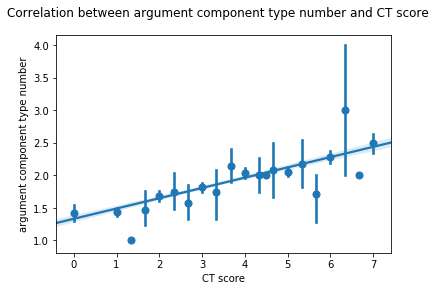

In [126]:
fig = plt.figure()
fig.suptitle('Correlation between argument component type number and CT score')
sns.regplot(x="CT score", y="argument component type number", data=component_class_nums_data , x_estimator=np.mean)
plt.show()
# g.set(xlabel="comment Score",ylabel="kind of argument component", title="Kinds of argument component Vs Score")

In [127]:
fig.savefig('argument component types.png', dpi=fig.dpi)

In [142]:
from scipy import stats
from numpy import corrcoef

In [152]:
print (component_class_nums_data['CT score'][0])

3.0


In [149]:
def pearsonSimilar(inA,inB):  
    if len(inA)<3:  
        return 1.0  
#     return 0.5+0.5*np.corrcoef(inA,inB,rowvar=0)[0][1]  
    return np.corrcoef(inA,inB,rowvar=0)[0][1]

In [166]:
list1 = [float(item) for item in component_class_nums_data['CT score']]
list2 = [float(item) for item in component_class_nums_data['argument component type number']]
print (stats.pearsonr(np.array(list2),np.array(list1)))
# print (pearsonSimilar(list2.mean,list1))
# print (list2)
print (len(list1), len(list2))


(nan, 1.0)
2868 2868


In [163]:
list1 = [1,2,3]
list2 = [3,-4,5]
print (np.corrcoef(list1, list2)[0, 1])

0.211603684758


In [75]:
# comment_scores = np.array(comment_scores)
# component_class_nums = np.array(component_class_nums)
# # sns.set()
# g = sns.regplot(comment_scores, component_class_nums, order=2)
# g.set(xlabel="comment Score",ylabel="kind of argument component", title="Kinds of argument component Vs Score")

 ###  the number of  every component ***Vs*** Score

In [76]:
# component_nums, comment_scores
claims_num  = [item[0] for item in component_nums]
premis_num = [item[1] for item in component_nums]
empty_num = [item[2] for item in component_nums]
major_claim = [item[3] for item in component_nums]

In [77]:
# print (claims_num)

In [78]:
sent_num_data = pd.DataFrame({"claim": claims_num,
                        "premise": premis_num,
                        "None": empty_num,
                        "major claim": major_claim,
                        "CT score": comment_scores
                              })

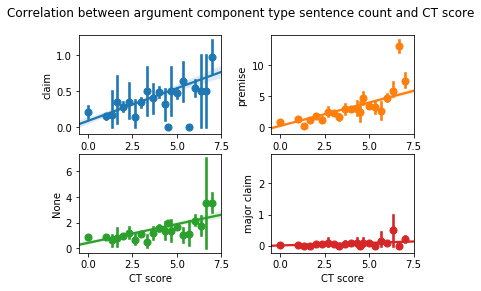

In [140]:
# Create a figure instance, and the two subplots
fig = plt.figure()
fig.suptitle('Correlation between argument component type sentence count and CT score')
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)
sns.regplot(x="CT score", y="claim", data=sent_num_data, ax=ax1, x_estimator=np.mean)
sns.regplot(x="CT score", y="premise", data=sent_num_data, ax=ax2,x_estimator=np.mean)
sns.regplot(x="CT score", y="None", data=sent_num_data, ax=ax3,x_estimator=np.mean)
sns.regplot(x="CT score", y="major claim", data=sent_num_data, ax=ax4,x_estimator=np.mean)
plt.show()

In [141]:
fig.savefig('sentence number.png', dpi=fig.dpi)

In [148]:
list1 = sent_num_data['CT score']
list2 = sent_num_data['major claim']
print (stats.pearsonr(list2,list1))

(nan, 1.0)


### the ratio of component Vs Score

In [81]:
ratios = []
for t in texts:
    ratios.append(component_ratio(t))
ratios = np.array(ratios)

In [82]:
claims_ratio = [item[0] for item in ratios]
premis_ratio = [item[1] for item in ratios]
empty_ratio = [item[2] for item in ratios]
major_claim_ratio = [item[3] for item in ratios]

In [83]:
ratio_data = pd.DataFrame({"claim": claims_ratio,
                        "premis": premis_ratio,
                        "None": empty_ratio,
                        "major_claim": major_claim_ratio,
                        "score": comment_scores
                              }) # I increased your errors so I could see them

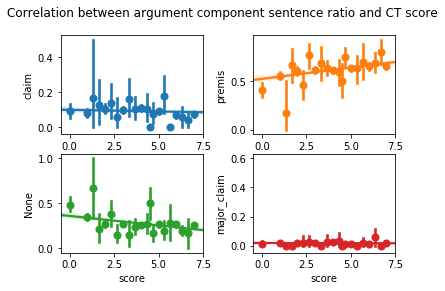

In [136]:
# Create a figure instance, and the two subplots
fig = plt.figure()
# Correlation between each argument component word ratio and CT score
fig.suptitle('Correlation between argument component sentence ratio and CT score')
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)
sns.regplot(x="score", y="claim", data=ratio_data, ax=ax1,x_estimator=np.mean)
sns.regplot(x="score", y="premis", data=ratio_data, ax=ax2,x_estimator=np.mean)
sns.regplot(x="score", y="None", data=ratio_data, ax=ax3,x_estimator=np.mean)
sns.regplot(x="score", y="major_claim", data=ratio_data, ax=ax4,x_estimator=np.mean)
plt.show()

In [137]:
fig.savefig('sentence ratio.png', dpi=fig.dpi)

### Word count of component Vs Score

In [86]:
comp_word_count = []
for item in texts: 
    comp_word_count.append(component_word_count(item))

In [87]:
claims_word_count = [item[0] for item in comp_word_count]
premis_word_count = [item[1] for item in comp_word_count]
empty_word_count = [item[2] for item in comp_word_count]
major_claim_word_count = [item[3] for item in comp_word_count]

In [88]:
word_count_data = pd.DataFrame({"claim": claims_word_count,
                        "premis": premis_word_count,
                        "None": empty_word_count,
                        "major claim": major_claim_word_count,
                        "score": comment_scores
                              })

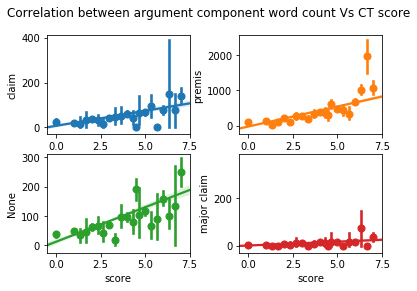

In [132]:
# Create a figure instance, and the two subplots
fig = plt.figure()
fig.suptitle('Correlation between argument component word count Vs CT score')
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)
sns.regplot(x="score", y="claim", data=word_count_data, ax=ax1,x_estimator=np.mean)
sns.regplot(x="score", y="premis", data=word_count_data, ax=ax2,x_estimator=np.mean)
sns.regplot(x="score", y="None", data=word_count_data, ax=ax3,x_estimator=np.mean)
sns.regplot(x="score", y="major claim", data=word_count_data, ax=ax4,x_estimator=np.mean)
plt.show()

In [146]:
fig.savefig('word count.png', dpi=fig.dpi)

### Word ratio of componet Vs Score

In [91]:
word_ratios = []
for item in texts:
    word_ratios.append(component_word_natio(item))

In [92]:
claims_word_ratio = [item[0] for item in word_ratios]
premis_word_ratio = [item[1] for item in word_ratios]
empty_word_ratio = [item[2] for item in word_ratios]
major_claim_word_ratio = [item[3] for item in word_ratios]

In [93]:
word_ratio_data = pd.DataFrame({"claim": claims_word_ratio,
                        "premis": premis_word_ratio,
                        "None": empty_word_ratio,
                        "major_claim": major_claim_word_ratio,
                        "score": comment_scores
                              })

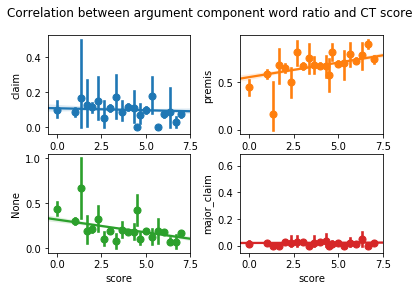

In [134]:
# Create a figure instance, and the two subplots
fig = plt.figure()
fig.suptitle('Correlation between argument component word ratio and CT score')
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.35, hspace=None)
sns.regplot(x="score", y="claim", data=word_ratio_data, ax=ax1,x_estimator=np.mean)
sns.regplot(x="score", y="premis", data=word_ratio_data, ax=ax2,x_estimator=np.mean)
sns.regplot(x="score", y="None", data=word_ratio_data, ax=ax3,x_estimator=np.mean)
sns.regplot(x="score", y="major_claim", data=word_ratio_data, ax=ax4,x_estimator=np.mean)
plt.show()

In [135]:
fig.savefig('word ratio.png', dpi=fig.dpi)

## Store the data into pickle file

In [96]:
# integrete feature vectors
new_component_class_nums = np.array([[item] for item in component_class_nums])
component_nums = np.array(component_nums)

In [97]:
# import itertools
vectors = np.concatenate((new_component_class_nums,
                       component_nums,
                       ratios,
                       comp_word_count,
                       word_ratios
                      ),axis=1)


In [98]:
text_compo_dic = {}
for i in range(len(texts)):
    text_compo_dic[texts[i]] = vectors[i]

In [99]:
import pickle
with open('argument_component.pickle', 'wb') as handle:
    pickle.dump(text_compo_dic, handle, protocol=pickle.HIGHEST_PROTOCOL)